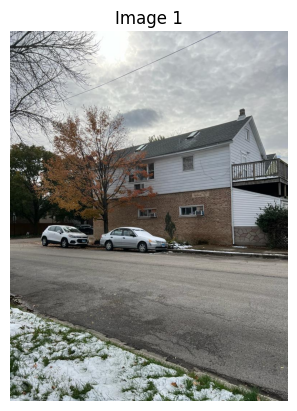

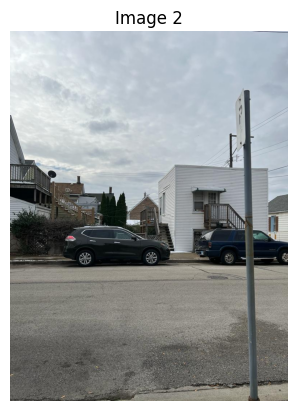

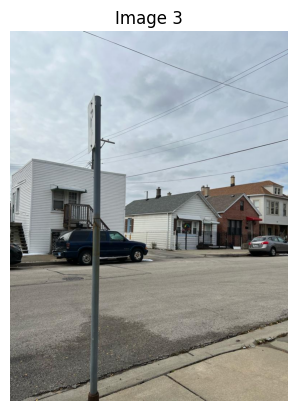

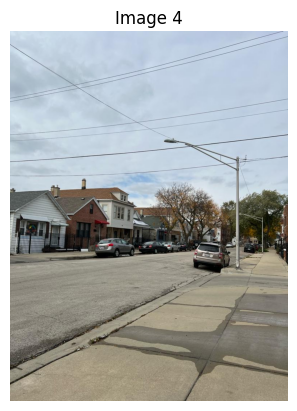

In [1]:
################## Section 1 = Display the images to be stitched ##################
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image
img1 = cv2.imread("image1.jpeg")
img2 = cv2.imread("image2.jpeg")
img3 = cv2.imread("image3.jpeg")
img4 = cv2.imread("image4.jpeg")

# Get the dimensions of img1
height, width, _ = img1.shape

# Resize img2, img3, and img4 to match img1 dimensions
resized_img2 = cv2.resize(img2, (width, height))
resized_img3 = cv2.resize(img3, (width, height))
resized_img4 = cv2.resize(img4, (width, height))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)


# Display image
plt.figure()
plt.imshow(img1)
plt.axis('off')  # Turn off the axis labels and ticks
plt.title('Image 1')
plt.show()

plt.figure()
plt.imshow(img2)
plt.axis('off')  # Turn off the axis labels and ticks
plt.title('Image 2')
plt.show()

plt.figure()
plt.imshow(img3)
plt.axis('off')  # Turn off the axis labels and ticks
plt.title('Image 3')
plt.show()

plt.figure()
plt.imshow(img4)
plt.axis('off')  # Turn off the axis labels and ticks
plt.title('Image 4')
plt.show()

#######################################################################################


I will be choosing image 2 as a reference image. Since it is in the middle <br>


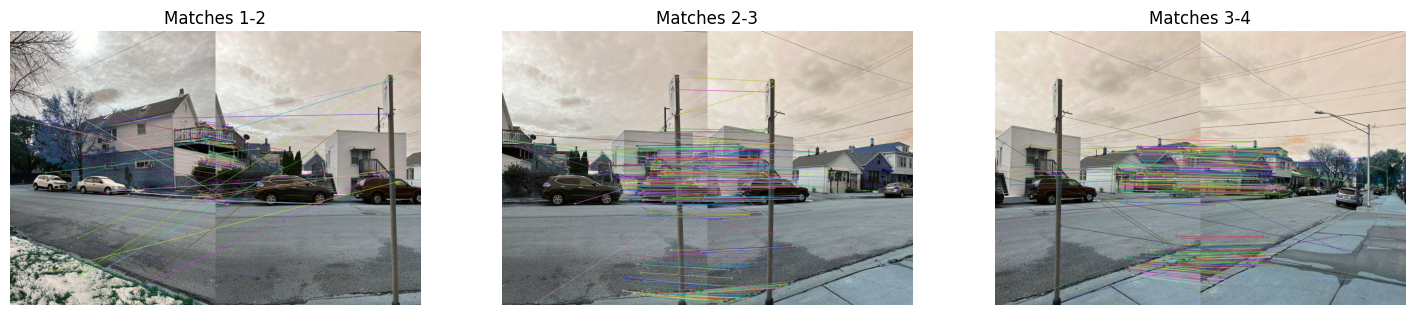

In [2]:

# Load your images (img1, img2, img3, img4)
# Assuming you have already loaded them

################## Section 5.2 = Feature Matching ##################
# Step 1: Feature Matching
sift = cv2.SIFT_create()

# Compute SIFT keypoints and descriptors for each image
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
kp3, des3 = sift.detectAndCompute(img3, None)
kp4, des4 = sift.detectAndCompute(img4, None)

# Match descriptors between img1 and img2
bf = cv2.BFMatcher()
matches12 = bf.knnMatch(des1, des2, k=2)
matches23 = bf.knnMatch(des2, des3, k=2)
matches34 = bf.knnMatch(des3, des4, k=2)

# Apply Lowe's ratio test
good_matches12 = []
for m, n in matches12:
    if m.distance < 0.75 * n.distance:
        good_matches12.append(m)

good_matches23 = []
for m, n in matches23:
    if m.distance < 0.75 * n.distance:
        good_matches23.append(m)

good_matches34 = []
for m, n in matches34:
    if m.distance < 0.75 * n.distance:
        good_matches34.append(m)

# Visualize tentative correspondences (optional)
img_matches12 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches12, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches23 = cv2.drawMatches(img2, kp2, img3, kp3, good_matches23, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches34 = cv2.drawMatches(img3, kp3, img4, kp4, good_matches34, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(18, 6))
plt.subplot(131), plt.imshow(cv2.cvtColor(img_matches12, cv2.COLOR_BGR2RGB)), plt.axis('off'),plt.title("Matches 1-2")
plt.subplot(132), plt.imshow(cv2.cvtColor(img_matches23, cv2.COLOR_BGR2RGB)), plt.axis('off'),plt.title("Matches 2-3")
plt.subplot(133), plt.imshow(cv2.cvtColor(img_matches34, cv2.COLOR_BGR2RGB)), plt.axis('off'),plt.title("Matches 3-4")
plt.show()
###################################################################

################## Section 3 = Homography Estimation ##################

# Step 2: Homography Estimation with RANSAC
src_pts12 = np.float32([kp1[m.queryIdx].pt for m in good_matches12]).reshape(-1, 1, 2)
dst_pts12 = np.float32([kp2[m.trainIdx].pt for m in good_matches12]).reshape(-1, 1, 2)
H12, _ = cv2.findHomography(src_pts12, dst_pts12, cv2.RANSAC, 5.0)

src_pts23 = np.float32([kp2[m.queryIdx].pt for m in good_matches23]).reshape(-1, 1, 2)
dst_pts23 = np.float32([kp3[m.trainIdx].pt for m in good_matches23]).reshape(-1, 1, 2)
H23, _ = cv2.findHomography(src_pts23, dst_pts23, cv2.RANSAC, 5.0)

src_pts34 = np.float32([kp3[m.queryIdx].pt for m in good_matches34]).reshape(-1, 1, 2)
dst_pts34 = np.float32([kp4[m.trainIdx].pt for m in good_matches34]).reshape(-1, 1, 2)
H34, _ = cv2.findHomography(src_pts34, dst_pts34, cv2.RANSAC, 5.0)

###################################################################


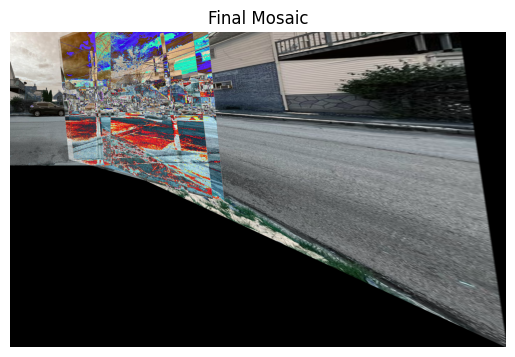

In [3]:
################## Section 4 = Image Warping ##################
# Define the height and width of the images
height, width = img1.shape[:2]

# Get the corners of the warped images
corners1 = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)
corners2 = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)
corners3 = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)
corners4 = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)

# Warp the corners to find the new size of the mosaic
new_corners1 = cv2.perspectiveTransform(corners1, np.linalg.inv(H12))
new_corners2 = cv2.perspectiveTransform(corners2, np.linalg.inv(H23))
new_corners3 = cv2.perspectiveTransform(corners3, np.linalg.inv(H34))
new_corners4 = np.float32([[0, 0], [0, height - 1], [width - 1, height - 1], [width - 1, 0]]).reshape(-1, 1, 2)

# Calculate the size of the output mosaic
mosaic_width = int(max(new_corners1[:, :, 0].max(), new_corners2[:, :, 0].max(), new_corners3[:, :, 0].max(), new_corners4[:, :, 0].max(), width))
mosaic_height = int(max(new_corners1[:, :, 1].max(), new_corners2[:, :, 1].max(), new_corners3[:, :, 1].max(), new_corners4[:, :, 1].max(), height))

# Warp img1 into reference frame (img2)
warped_img1 = cv2.warpPerspective(img1, np.linalg.inv(H12), (mosaic_width, mosaic_height))

# Warp img2 into reference frame (img3)
warped_img2 = cv2.warpPerspective(img2, np.linalg.inv(H23), (mosaic_width, mosaic_height))

# Warp img3 into reference frame (img4)
warped_img3 = cv2.warpPerspective(img3, np.linalg.inv(H34), (mosaic_width, mosaic_height))

# Warp img4 into reference frame (img3)
warped_img4 = cv2.warpPerspective(img4, np.linalg.inv(H34), (mosaic_width, mosaic_height))

# Composite warped images into a single mosaic
mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)

# Add the reference image (img2) to the mosaic
mosaic[0:height, 0:width] += img2

# Add the warped images to the mosaic
mosaic[0:mosaic_height, 0:mosaic_width] += warped_img1
mosaic[0:mosaic_height, 0:mosaic_width] += warped_img2
mosaic[0:mosaic_height, 0:mosaic_width] += warped_img3
mosaic[0:mosaic_height, 0:mosaic_width] += warped_img4

# Display the final mosaic
plt.figure()
plt.imshow(cv2.cvtColor(mosaic, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Final Mosaic")
plt.show()

<span style="color:blue">
    This is the best I could get for the panorama image I could generate.<br>
    ###################################################################